# Johan Hedenström
Explorative

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import math
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import lists
from moving_binary_filter import filter

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst' #'../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)

In [3]:
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events,coin,zdrop)

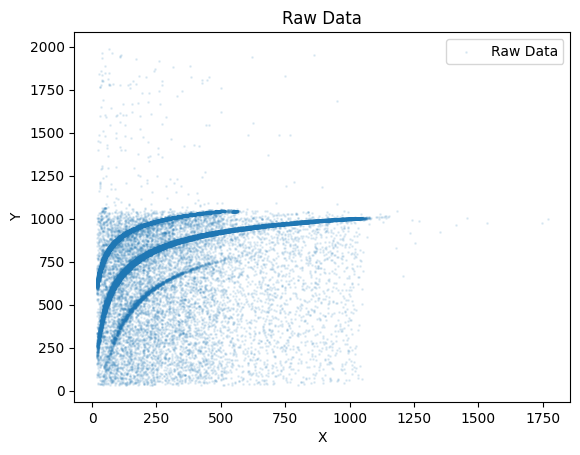

In [4]:
X = np.array(outLists[0])
Y = np.array(outLists[1])

# 1. Visualize the raw data
plt.scatter(X, Y, s=1, alpha=0.1, label='Raw Data')
plt.title("Raw Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

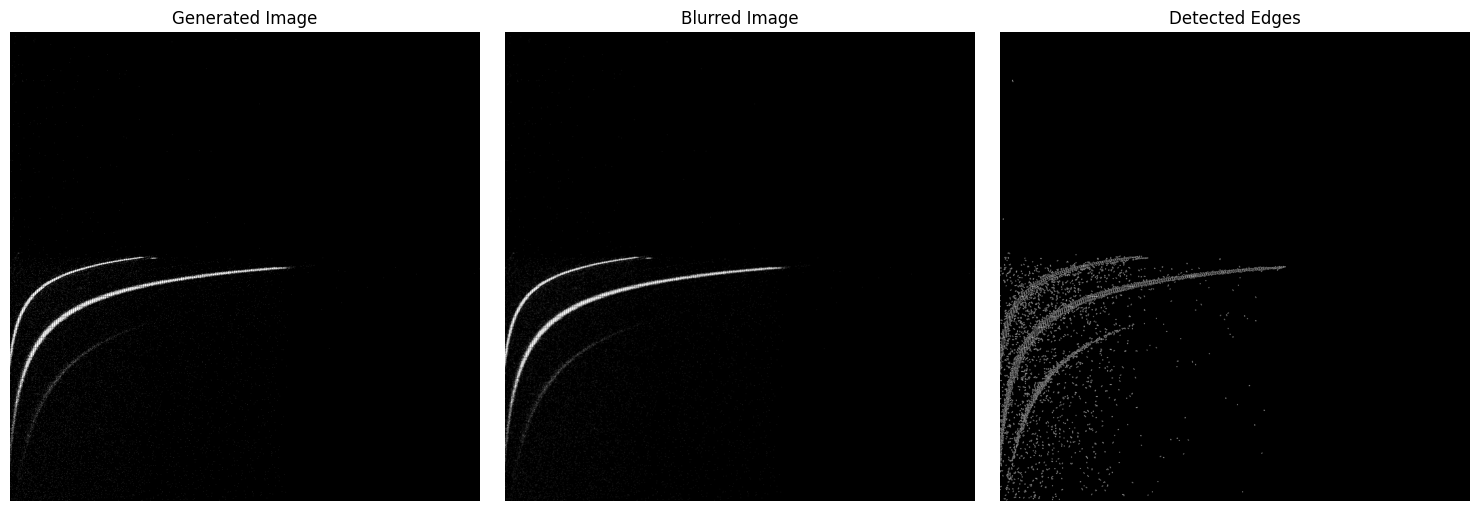

In [5]:
import numpy as np
import cv2
from scipy.interpolate import splprep, splev
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Step 1: Convert X, Y into an image
# Define image resolution (e.g., 2000x2000 pixels)
img_size = (2000, 2000)
img = np.zeros(img_size, dtype=np.uint8)

# Normalize X and Y to fit the image grid
x_norm = ((X - X.min()) / (X.max() - X.min()) * (img_size[1] - 1)).astype(int)

# Invert Y by subtracting the normalized values from the maximum pixel value
y_norm = (img_size[0] - 1 - ((Y - Y.min()) / (Y.max() - Y.min()) * (img_size[0] - 1))).astype(int)


# Draw points on the image
for x, y in zip(x_norm, y_norm):
    img[y, x] = 255  # Set the pixel to white

# Step 2: Image Processing
# Apply Gaussian blur to smooth the image
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Use Canny Edge Detection to detect trajectories
edges = cv2.Canny(blurred_img, 50, 150)

# Step 3: Visualization
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Generated Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

# Blurred Image
plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

# Edges Detected
plt.subplot(1, 3, 3)
plt.title("Detected Edges")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

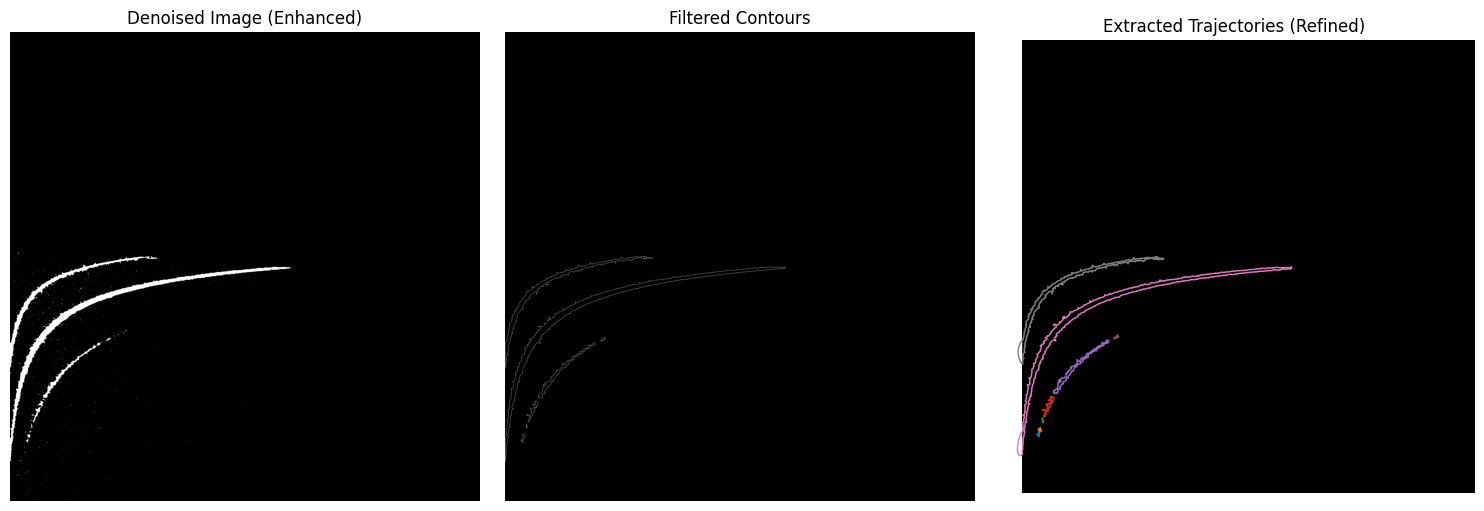

In [6]:
def angle_between_vectors(v1, v2):
    """Calculate the angle (in degrees) between two vectors."""
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0)))

def connect_contours_safely(contours, tree, endpoints, contour_map, max_dist=25, max_angle=30):
    """
    Connect contours if their endpoints are close and directions are consistent.
    """
    connected_contours = []
    used_contours = set()

    for i, contour in enumerate(contours):
        if i in used_contours:
            continue

        # Initialize the current trajectory group
        merged_points = [contour[:, 0, :]]
        used_contours.add(i)

        # Analyze endpoints
        for point_type in ["start", "end"]:
            endpoint = contour[0, 0] if point_type == "start" else contour[-1, 0]
            direction = contour[1, 0] - endpoint if point_type == "start" else endpoint - contour[-2, 0]

            # Find nearest endpoint
            dist, idx = tree.query(endpoint)
            if dist < max_dist:
                neighbor_index, neighbor_type = contour_map[idx]

                if neighbor_index not in used_contours:
                    # Check directional consistency
                    neighbor = contours[neighbor_index]
                    neighbor_endpoint = neighbor[0, 0] if neighbor_type == "start" else neighbor[-1, 0]
                    neighbor_direction = neighbor[1, 0] - neighbor_endpoint if neighbor_type == "start" else neighbor_endpoint - neighbor[-2, 0]

                    angle = angle_between_vectors(direction, neighbor_direction)
                    if angle < max_angle:
                        # Add neighbor to the group
                        if neighbor_type == "start":
                            merged_points.append(neighbor[:, 0, :])
                        else:
                            merged_points.append(neighbor[::-1, 0, :])  # Reverse order
                        used_contours.add(neighbor_index)

        # Merge all points and append to the result
        connected_contours.append(np.vstack(merged_points))

    return connected_contours

def extract_endpoints(contours):
    """Extract start and end points of contours."""
    endpoints = []
    contour_map = []
    for i, contour in enumerate(contours):
        start_point = contour[0, 0]
        end_point = contour[-1, 0]
        endpoints.append(start_point)
        endpoints.append(end_point)
        contour_map.append((i, "start"))
        contour_map.append((i, "end"))

    return np.array(endpoints), contour_map

# Step 1: Enhanced Morphological Operations to Denoise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
cleaned_img = cv2.morphologyEx(blurred_img, cv2.MORPH_CLOSE, kernel)
_, cleaned_img = cv2.threshold(cleaned_img, 50, 255, cv2.THRESH_BINARY)

# Step 2: Detect Contours with Filtering
contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_length = 40  # Adjust to capture smaller segments
filtered_contours = [
    contour for contour in contours if cv2.arcLength(contour, closed=False) > min_contour_length
]

# Step 3: Extract endpoints and build k-d tree
endpoints, contour_map = extract_endpoints(filtered_contours)
tree = KDTree(endpoints)

# Step 4: Safely connect contours
connected_contours = connect_contours_safely(
    filtered_contours, tree, endpoints, contour_map, max_dist=25, max_angle=30
)

# Step 5: Fit smooth curves to connected contours
trajectories = []
for points in connected_contours:
    if len(points) > 10:  # Only consider significant merged contours
        x, y = points[:, 0], points[:, 1]
        tck, _ = splprep([x, y], s=5)
        smooth_x, smooth_y = splev(np.linspace(0, 1, 1000), tck)
        trajectories.append((smooth_x, smooth_y))

# Visualization
plt.figure(figsize=(15, 5))

# Denoised Image
plt.subplot(1, 3, 1)
plt.title("Denoised Image (Enhanced)")
plt.imshow(cleaned_img, cmap='gray')
plt.axis('off')

# Filtered Contours
contour_img = np.zeros_like(cleaned_img)
cv2.drawContours(contour_img, filtered_contours, -1, (255, 255, 255), 1)
plt.subplot(1, 3, 2)
plt.title("Filtered Contours")
plt.imshow(contour_img, cmap='gray')
plt.axis('off')

# Smooth Trajectories
plt.subplot(1, 3, 3)
plt.title("Extracted Trajectories (Refined)")
plt.imshow(contour_img, cmap='gray')
for smooth_x, smooth_y in trajectories:
    plt.plot(smooth_x, smooth_y, linewidth=1)
plt.axis('off')

plt.tight_layout()
plt.show()


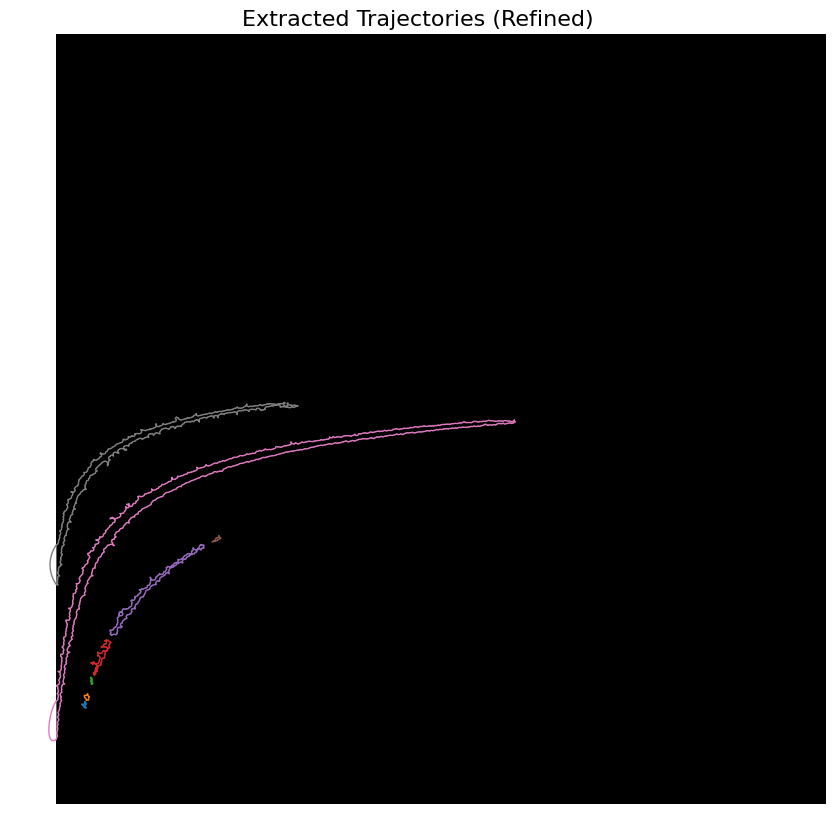

In [7]:
plt.figure(figsize=(20, 10))  # Set a larger figure size
plt.title("Extracted Trajectories (Refined)", fontsize=16)
plt.imshow(contour_img, cmap='gray')
for smooth_x, smooth_y in trajectories:
    plt.plot(smooth_x, smooth_y, linewidth=1)
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()


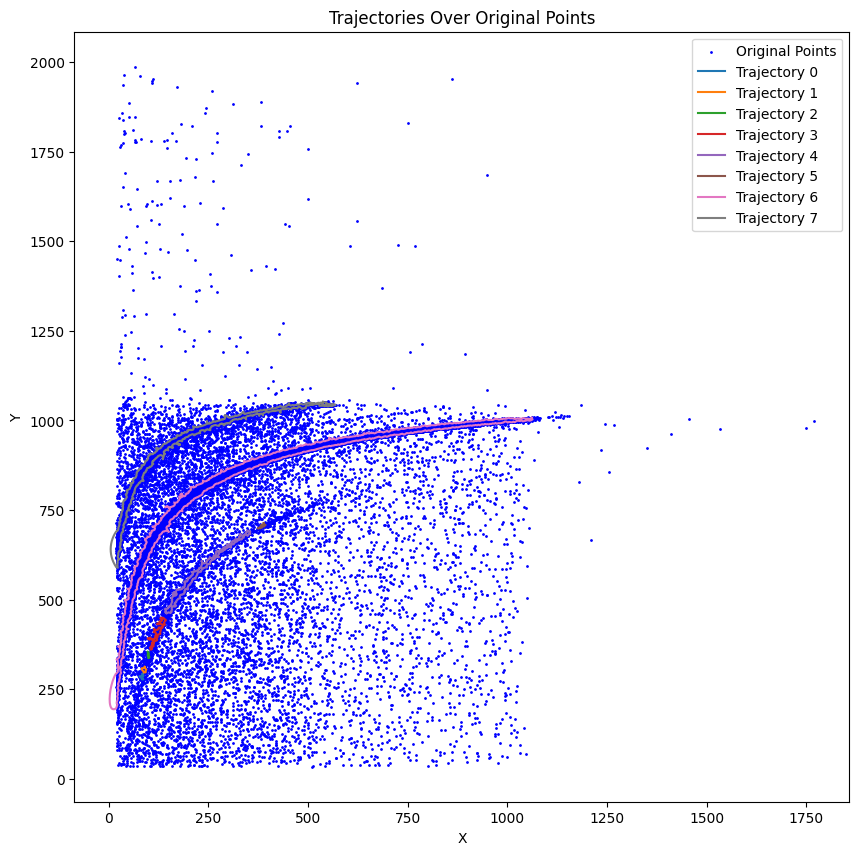

In [8]:
plt.figure(figsize=(10, 10))

# Plot the original X and Y values
plt.scatter(X, Y, color='blue', s=1, label='Original Points')

# Plot the trajectories
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    plt.plot(trajectory_x, trajectory_y, label=f'Trajectory {i}')

plt.title("Trajectories Over Original Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


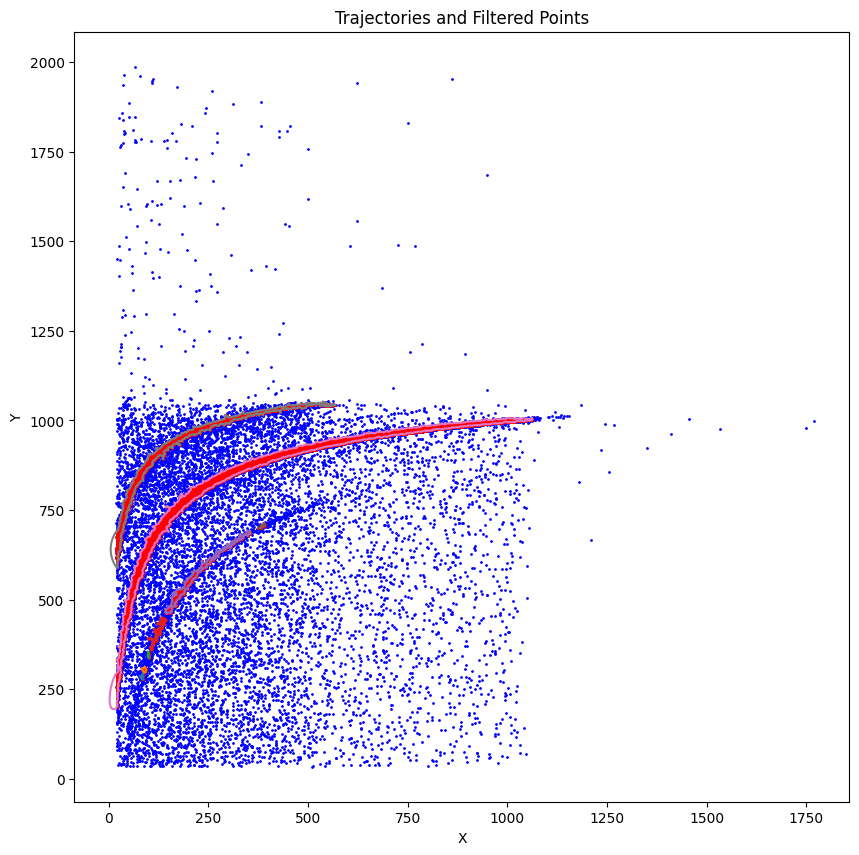

In [9]:
# Create a figure
plt.figure(figsize=(10, 10))

# Plot the original X and Y values as a scatter plot
plt.scatter(X, Y, color='blue', s=1, label='Original Points')

# Initialize an array to mark points that are inside any trajectory region
inside_points_mask = np.zeros(len(X), dtype=bool)

# Process each trajectory
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    # Create a closed polygon path from the trajectory
    trajectory_path = Path(np.column_stack((trajectory_x, trajectory_y)))
    
    # Determine if points are inside this trajectory
    points = np.column_stack((X, Y))
    inside_trajectory = trajectory_path.contains_points(points)
    
    # Update the mask to include points inside this trajectory
    inside_points_mask |= inside_trajectory
    
    # Optionally plot the trajectory
    plt.plot(trajectory_x, trajectory_y, label=f'Trajectory {i}')

# Filter the points based on the mask
filtered_X = X[inside_points_mask]
filtered_Y = Y[inside_points_mask]

# Plot the filtered points
plt.scatter(filtered_X, filtered_Y, color='red', s=1, label='Filtered Points')

plt.title("Trajectories and Filtered Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [10]:
# Precompute bounding boxes with padding to include edge cases
def get_bounding_box(x, y, padding=0.01):
    return (np.min(x) - padding, np.max(x) + padding,
            np.min(y) - padding, np.max(y) + padding)

# Initialize an array to mark points that are inside any trajectory region
inside_points_mask = np.zeros(len(X), dtype=bool)

# Process each trajectory
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    # Compute bounding box for trajectory with padding
    x_min, x_max, y_min, y_max = get_bounding_box(trajectory_x, trajectory_y)
    
    # Filter points within the bounding box
    inside_bbox = (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
    bbox_points = np.column_stack((X[inside_bbox], Y[inside_bbox]))
    
    # Check if points are inside the trajectory path
    trajectory_path = Path(np.column_stack((trajectory_x, trajectory_y)))
    inside_trajectory = trajectory_path.contains_points(bbox_points)
    
    # Update the mask with indices of points inside the trajectory
    bbox_indices = np.where(inside_bbox)[0]
    inside_points_mask[bbox_indices] |= inside_trajectory

# Filter the points based on the mask
filtered_X = X[inside_points_mask]
filtered_Y = Y[inside_points_mask]


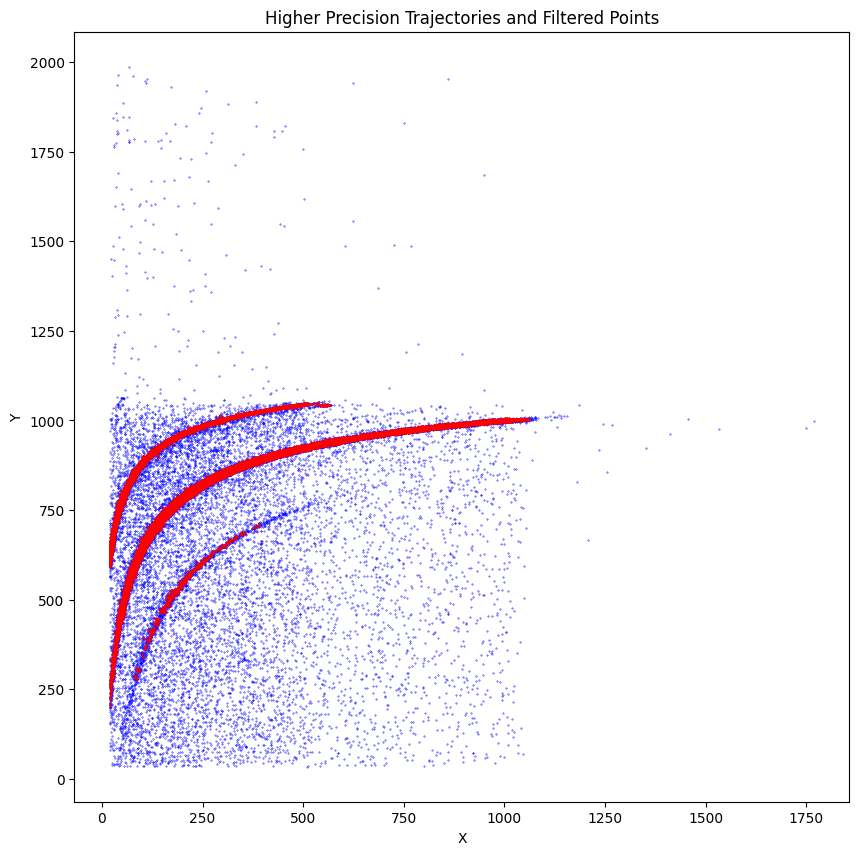

In [11]:
# Precompute bounding boxes with padding to include edge cases
def get_bounding_box(x, y, padding=0.01):
    return (np.min(x) - padding, np.max(x) + padding,
            np.min(y) - padding, np.max(y) + padding)

# Initialize an array to mark points that are inside any trajectory region
inside_points_mask = np.zeros(len(X), dtype=bool)

# Process each trajectory
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    # Compute bounding box for trajectory with padding
    x_min, x_max, y_min, y_max = get_bounding_box(trajectory_x, trajectory_y)
    
    # Filter points within the bounding box
    inside_bbox = (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
    bbox_points = np.column_stack((X[inside_bbox], Y[inside_bbox]))
    
    # Check if points are inside the trajectory path
    trajectory_path = Path(np.column_stack((trajectory_x, trajectory_y)))
    inside_trajectory = trajectory_path.contains_points(bbox_points)
    
    # Update the mask with indices of points inside the trajectory
    bbox_indices = np.where(inside_bbox)[0]
    inside_points_mask[bbox_indices] |= inside_trajectory

# Filter the points based on the mask
filtered_X = X[inside_points_mask]
filtered_Y = Y[inside_points_mask]

# Plot the results
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, color='blue', s=0.1, label='Original Points')
plt.scatter(filtered_X, filtered_Y, color='red', s=0.1, label='Filtered Points')

plt.title("Higher Precision Trajectories and Filtered Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
